<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%EA%B0%80%EC%9C%84%EB%B0%94%EC%9C%84%EB%B3%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [47]:
from PIL import Image
import matplotlib.pyplot as plt
import os, glob
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [40]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [48]:
image_dir_path = "/content/gdrive/MyDrive/AIFFEL/DATA"
image_dir_path_s = image_dir_path + "/scissor"
image_dir_path_r = image_dir_path + "/rock"
image_dir_path_p  = image_dir_path + "/paper"

resize_images(image_dir_path_s)
print("가위 이미지 resize 완료!")

resize_images(image_dir_path_r)
print("바위 이미지 resize 완료!")

resize_images(image_dir_path_p)
print("보 이미지 resize 완료!")



994  images to be resized.
994  images resized.
가위 이미지 resize 완료!
1105  images to be resized.
1105  images resized.
바위 이미지 resize 완료!
1108  images to be resized.
1108  images resized.
보 이미지 resize 완료!


In [49]:

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("이미지 개수는", idx,"입니다.")
    return imgs, labels



이미지 개수는 3207 입니다.
X_train shape: (2565, 28, 28, 3)
y_train shape: (2565,)
X_test shape: (642, 28, 28, 3)
y_test shape: (642,)


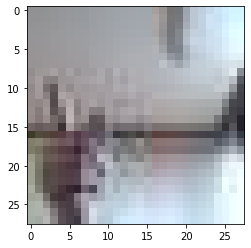

In [54]:
image_dir_path = "/content/gdrive/MyDrive/AIFFEL/DATA"
(X, y)=load_data(image_dir_path,3207)

# 입력은 0~1 사이의 값으로 정규화
X_norm = X/255.0 
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
plt.imshow(X_train[44],cmap=plt.cm.binary)

In [55]:

n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=15

model=keras.models.Sequential()

model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [56]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(X_train, y_train, epochs=n_train_epoch)

Epoch 1/15
81/81 [==============================] - 1s 4ms/step - loss: 1.0648 - accuracy: 0.4550
Epoch 2/15
81/81 [==============================] - 0s 3ms/step - loss: 0.9311 - accuracy: 0.5809
Epoch 3/15
81/81 [==============================] - 0s 3ms/step - loss: 0.7335 - accuracy: 0.6982
Epoch 4/15
81/81 [==============================] - 0s 3ms/step - loss: 0.5918 - accuracy: 0.7595
Epoch 5/15
81/81 [==============================] - 0s 3ms/step - loss: 0.4637 - accuracy: 0.8285
Epoch 6/15
81/81 [==============================] - 0s 3ms/step - loss: 0.3991 - accuracy: 0.8464
Epoch 7/15
81/81 [==============================] - 0s 3ms/step - loss: 0.3512 - accuracy: 0.8635
Epoch 8/15
81/81 [==============================] - 0s 3ms/step - loss: 0.2664 - accuracy: 0.9057
Epoch 9/15
81/81 [==============================] - 0s 3ms/step - loss: 0.2203 - accuracy: 0.9212
Epoch 10/15
81/81 [==============================] - 0s 3ms/step - loss: 0.1962 - accuracy: 0.9302
Epoch 11/15
81/81 [

In [57]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

21/21 - 0s - loss: 0.2109 - accuracy: 0.9283
test_loss: 0.21086084842681885 
test_accuracy: 0.9283488988876343
